In [18]:
'''
Image Crop
'''
import cv2
import os
import pathlib
from tqdm import tqdm



DATASET_PATH = pathlib.Path(os.path.dirname(os.path.realpath('__file__'))).parent.parent / "dataset" / "SDD" / "luxteel" / "resnet_dataset" / "defect"
OUTPUT_PATH = pathlib.Path(os.path.dirname(os.path.realpath('__file__'))).parent.parent / "dataset" / "SDD" / "luxteel" / "resnet_dataset" / "defect_subset"

# create output folder
if not os.path.exists(OUTPUT_PATH.as_posix()):
    os.makedirs(OUTPUT_PATH.as_posix())
    
# parameters
_cols = 3
_rows = 3

# listup images
image_files = os.listdir(DATASET_PATH.as_posix())

# crop subset
for idx, f in tqdm(enumerate(image_files)):
    image = cv2.imread((DATASET_PATH / f).as_posix())
    x = image.shape[1]
    y = image.shape[0]
    for i in range(0, _rows):
        for j in range(0, _cols):
            roi = image[int(i*y/_rows):int(i*y/_rows+y/_rows) ,int(j*x/_cols):int(j*x/_cols+x/_cols)]
            cv2.imwrite((OUTPUT_PATH / f"{idx}_{i}{j}.png").as_posix(), roi)



169it [00:25,  6.73it/s]


In [38]:
# dataset preparation
# listup dataset
import random
import shutil

DEFECT_DATASET_PATH = pathlib.Path(os.path.dirname(os.path.realpath('__file__'))).parent.parent / "dataset" / "SDD" / "luxteel" / "resnet_dataset" / "defect_subset_640_400"
NORMAL_DATASET_PATH = pathlib.Path(os.path.dirname(os.path.realpath('__file__'))).parent.parent / "dataset" / "SDD" / "luxteel" / "resnet_dataset" / "normal_subset_640_400"
TRAIN_DATASET_PATH = pathlib.Path(os.path.dirname(os.path.realpath('__file__'))).parent.parent / "dataset" / "SDD" / "luxteel" / "resnet_dataset" / "train"
TEST_DATASET_PATH = pathlib.Path(os.path.dirname(os.path.realpath('__file__'))).parent.parent / "dataset" / "SDD" / "luxteel" / "resnet_dataset" / "test"

defect_image_files = os.listdir(DEFECT_DATASET_PATH.as_posix())
normal_image_files = os.listdir(NORMAL_DATASET_PATH.as_posix())

# random shuffle
random.shuffle(defect_image_files)
random.shuffle(normal_image_files)

# split dataset
trainset_rate = 0.7
defect_train_size = int(trainset_rate*len(defect_image_files))
normal_train_size = int(trainset_rate*len(normal_image_files))

# create directories
classes = ["defect", "normal"]
for c in classes:
    os.makedirs((TRAIN_DATASET_PATH/c).as_posix(), exist_ok=True)
    os.makedirs((TEST_DATASET_PATH/c).as_posix(), exist_ok=True)


# split defect data
for i, f in tqdm(enumerate(defect_image_files)):
    if i<=defect_train_size:
        shutil.copyfile((DEFECT_DATASET_PATH/f).as_posix(), (TRAIN_DATASET_PATH/"defect"/f).as_posix())
    else:
        shutil.copyfile((DEFECT_DATASET_PATH/f).as_posix(), (TEST_DATASET_PATH/"defect"/f).as_posix())
        
# split normal data
for i, f in tqdm(enumerate(normal_image_files)):
    if i<=normal_train_size:
        shutil.copyfile((NORMAL_DATASET_PATH/f).as_posix(), (TRAIN_DATASET_PATH/"normal"/f).as_posix())
    else:
        shutil.copyfile((NORMAL_DATASET_PATH/f).as_posix(), (TEST_DATASET_PATH/"normal"/f).as_posix())



630it [00:01, 511.78it/s]
1046it [00:01, 656.21it/s]


In [85]:
'''
Luxteel Defect Binary Classification Model using Residual Network
'''
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import pathlib

import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as transform
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torchinfo import summary

import random
import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline

# hyper parameters
DATA_BATCH_SIZE = 10
EPOCHS = 30
LEARNING_RATE = 0.01
GRAD_CLIP = 0.12
WEIGHT_DECAY = 0.0001


DATASET_PATH = pathlib.Path(os.path.dirname(os.path.realpath('__file__'))).parent.parent / "dataset" / "SDD" / "luxteel" / "resnet_dataset"
print(DATASET_PATH) # show dataset path

# train dataset preparation
classes = ['normal', 'defect']   # two class
dataset = ImageFolder(DATASET_PATH, transform=transform.ToTensor()) # set image dataset directory and data transform
dataloader = DataLoader(dataset, batch_size=DATA_BATCH_SIZE) # data loader with batch size 10 (change if more GPU memory is available)

print(torch.__version__) # check CUDA toolkit version (must be matched CUDA Toolkit version and Pytorch version)
# [Note!] use pytorch 2.1.2, CUDA 11.8 on python virtual environment(using pip)
# [Note!] pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


# calc mean and std for image normalization
_sum_channels = 0
_squared_sum_channels =0
_total_batches = 0

for data, _ in tqdm(dataloader):
    _sum_channels += torch.mean(data, dim=[0,2,3]) # calc mean for each channels (dim=Batch, Channel, Height, Width)
    _squared_sum_channels += torch.mean(data**2, dim=[0,2,3])
    _total_batches += 1
mean = _sum_channels / _total_batches
std = (_squared_sum_channels / _squared_sum_channels - mean ** 2) ** 0.5

print(_sum_channels, _squared_sum_channels, _total_batches)
print(f"Mean : {mean}, Std:{std}")

# normalization(0~1) of dataset images
stats = (tuple(mean.tolist()), tuple(std.tolist()))
train_transform = transform.Compose([transform.ToTensor(), transform.Normalize(*stats, inplace=True)])
test_transform = transform.Compose([transform.ToTensor(), transform.Normalize(*stats)])

# performing transformation for all dataset
train_dataset = ImageFolder((DATASET_PATH/"train").as_posix(), train_transform)
test_dataset = ImageFolder((DATASET_PATH/"test").as_posix(), test_transform)

# create data loader (use page-lock to transfer the data into GPU memory)
train_dataloader = DataLoader(train_dataset, batch_size=DATA_BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=DATA_BATCH_SIZE, num_workers=4, pin_memory=True)

# device selection function (GPU, CPU, MPS for MacOS)
def get_device_use():
    if torch.cuda.is_available():
        return torch.device('cuda')
    elif torch.backends.mps.is_available():
        return torch.device('mps')
    else:
        return torch.device('cpu')
device = get_device_use()
print(f"Selected Device : {device}")

# transfer data into the selected device
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dataloader, device) -> None:
        self.__dataloader = dataloader
        self.__device = device
        
    def __iter__(self):
        for b in self.__dataloader:
            yield to_device(b, self.__device)
            
    def __len__(self):
        return len(self.__dataloader)
    
train_dataloader = DeviceDataLoader(train_dataloader, device)
test_dataloader = DeviceDataLoader(test_dataloader, device)


C:\Users\elecu\dev\flame-autonomous\dataset\SDD\luxteel\resnet_dataset
2.1.2+cu118


100%|██████████| 168/168 [00:12<00:00, 13.72it/s]

tensor([48.8470, 48.8470, 48.8470]) tensor([15.8075, 15.8075, 15.8075]) 168
Mean : tensor([0.2908, 0.2908, 0.2908]), Std:tensor([0.9568, 0.9568, 0.9568])
Selected Device : cuda


In [ ]:
# training

# Residual Network
class ModelBase(nn.Module):
    
    @staticmethod
    def __accuracy(outputs, labels):
        _, preds = torch.max(outputs, dim=1)
        return torch.tensor(torch.sum(preds == labels).item() / len(preds))

    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        acc = self.__accuracy(out, labels)  
        return loss,acc
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = self.__accuracy(out, labels)    # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}, last_lr: {:.5f}".format(
            epoch+1, result['train_loss'], result['train_accuracy'], result['val_loss'], result['val_acc'], result['lrs'][-1]))
        
class ResNet(ModelBase):
    # resnet layer block : conv2d -> batch normalization -> ReLu
    @staticmethod
    def __conv_block(in_channels, out_channels, pool=False):
        # output dim and input dim are the same (kernel size=3, padding=1)
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), nn.BatchNorm2d(num_features=out_channels), nn.ReLU(inplace=True)]
        if pool: 
            layers.append(nn.MaxPool2d(kernel_size=2))  # max pooling with 2 dim kernel
        return nn.Sequential(*layers) # combine into single block
    
    def __init__(self, channels, n_classes):
        super().__init__()
        
        self.conv1 = self.__conv_block(channels, 64)
        self.conv2 = self.__conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(self.__conv_block(128, 128), self.__conv_block(128, 128))
        
        self.conv3 = self.__conv_block(128, 256, pool=True)
        self.conv4 = self.__conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(self.__conv_block(512, 512), self.__conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d((1,1)), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, n_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

# create resnet model
model = to_device(ResNet(channels=3, n_classes=2), device)

# show model summary (check model structure)
# model = ResNet(channels=3, n_classes=2)
# summary(model, input_size=(DATA_BATCH_SIZE, 3, 224, 224))


# use Adam Optimization function
optimizer = torch.optim.Adam(model.parameters(),LEARNING_RATE,amsgrad=True, weight_decay=WEIGHT_DECAY)

# model training
@torch.no_grad()
def evaluate(model, valid_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in valid_loader]
    return model.validation_epoch_end(outputs)

def get_learning_rate(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
def fit(epochs, max_lr, model, train_loader, val_loader,weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    history = []
    _optimizer = opt_func
    sched = torch.optim.lr_scheduler.OneCycleLR(_optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    for epoch in (range(epochs)):
        
        # Training Phase 
        model.train()
        train_losses = []
        train_accuracy= []
        lrs=[]
        for (batch_idx, batch) in enumerate(train_loader):
            loss,accuracy = model.training_step(batch)
            train_losses.append(loss)
            train_accuracy.append(accuracy)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            _optimizer.step()
            _optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_learning_rate(_optimizer))
            sched.step()
            if batch_idx % 60 == 0:
                print(f'Train Epoch: {epoch+1} [{batch_idx}/{len(train_loader)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss:.6f}, Accuracy: {accuracy:.4f}')

        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_accuracy'] = torch.stack(train_accuracy).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

print("Now start model training...")
history = fit(EPOCHS, LEARNING_RATE, model, train_dataloader, test_dataloader, grad_clip=GRAD_CLIP, weight_decay=WEIGHT_DECAY, opt_func=optimizer)

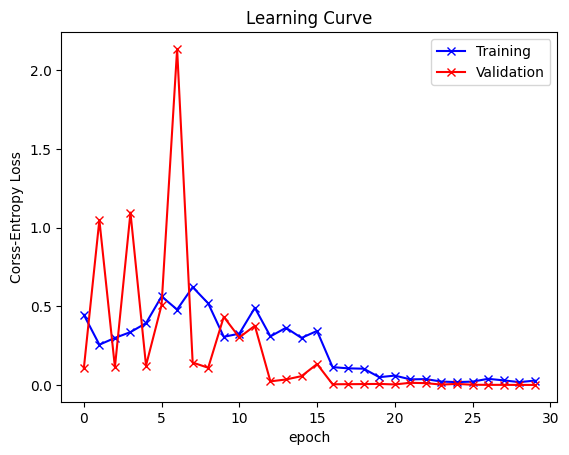

In [86]:
'''
Learning Curve Plot
'''
train_losses = [x.get('train_loss') for x in history]
val_losses = [x['val_loss'] for x in history]
plt.plot(train_losses, '-bx')
plt.plot(val_losses, '-rx')
plt.xlabel('epoch')
plt.ylabel('Corss-Entropy Loss')
plt.legend(['Training', 'Validation'])
plt.title('Learning Curve')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

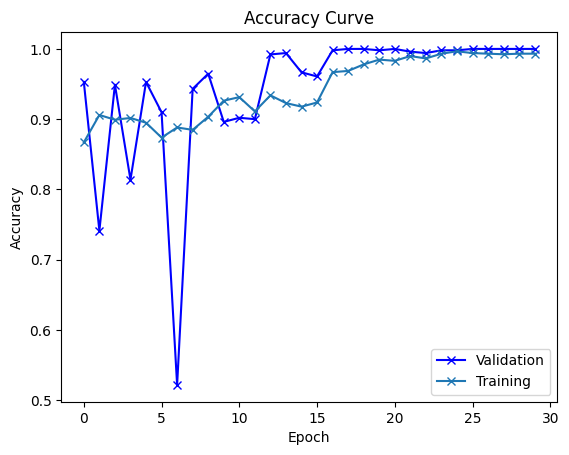

In [82]:
'''
Accuracy Plot
'''
train_accuracies= [x['train_accuracy'] for x in history]
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-bx')
plt.plot(train_accuracies, '-x')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Validation','Training'])
plt.title('Accuracy Curve')
plt.show

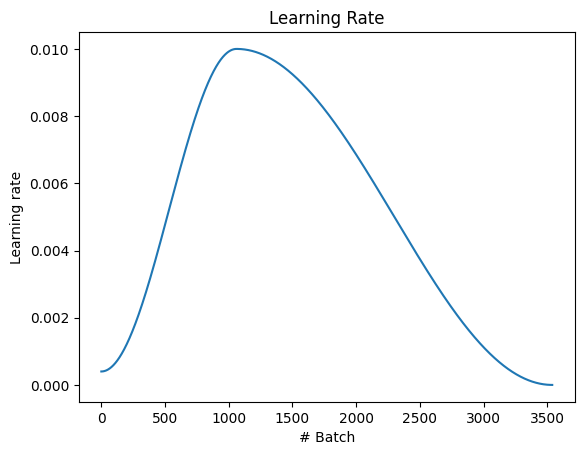

In [83]:
'''
Learning Rate Plot
'''

lrs = np.concatenate([x.get('lrs', []) for x in history])
plt.plot(lrs)
plt.xlabel('# Batch')
plt.ylabel('Learning rate')
plt.title('Learning Rate')
plt.show()

In [44]:
'''
Save to model file
'''
torch.save(model.state_dict(), './resnet9_sdd.pth')

In [134]:
input_shape = tuple(sdd_model.parameters())[0].size()
print("Input Shape:", input_shape)

Input Shape: torch.Size([64, 3, 3, 3])


In [135]:
# show model summary (check model structure)
t_model = ResNet(channels=3, n_classes=2)
summary(t_model, input_size=(DATA_BATCH_SIZE, 3, 640, 400))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [10, 2]                   --
├─Sequential: 1-1                        [10, 64, 640, 400]        --
│    └─Conv2d: 2-1                       [10, 64, 640, 400]        1,792
│    └─BatchNorm2d: 2-2                  [10, 64, 640, 400]        128
│    └─ReLU: 2-3                         [10, 64, 640, 400]        --
├─Sequential: 1-2                        [10, 128, 320, 200]       --
│    └─Conv2d: 2-4                       [10, 128, 640, 400]       73,856
│    └─BatchNorm2d: 2-5                  [10, 128, 640, 400]       256
│    └─ReLU: 2-6                         [10, 128, 640, 400]       --
│    └─MaxPool2d: 2-7                    [10, 128, 320, 200]       --
├─Sequential: 1-3                        [10, 128, 320, 200]       --
│    └─Sequential: 2-8                   [10, 128, 320, 200]       --
│    │    └─Conv2d: 3-1                  [10, 128, 320, 200]       147,584
│

Label: normal , Predicted: normal


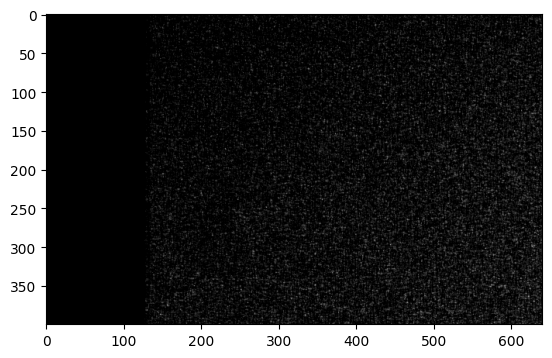

In [111]:
'''
Prediction from loaded model on memory
'''
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    model.eval()
    with torch.no_grad():
        yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_dataset.classes[preds[0].item()]

img, label = test_dataset[299]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_dataset.classes[label], ', Predicted:', predict_image(img, sdd_model))

In [88]:
'''
use saved model
'''
def get_device_use():
    if torch.cuda.is_available():
        return torch.device('cuda')
    elif torch.backends.mps.is_available():
        return torch.device('mps')
    else:
        return torch.device('cpu')
device = get_device_use()

sdd_model = to_device(ResNet(3, 2), device)
sdd_model.load_state_dict(torch.load('./resnet9_sdd.pth'))
evaluate(sdd_model, test_dataloader)

{'val_loss': 0.000604154251050204, 'val_acc': 1.0}

Elapsed Time : 0:00:00.019999
Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

ValueError: Input dimension should be at least 3

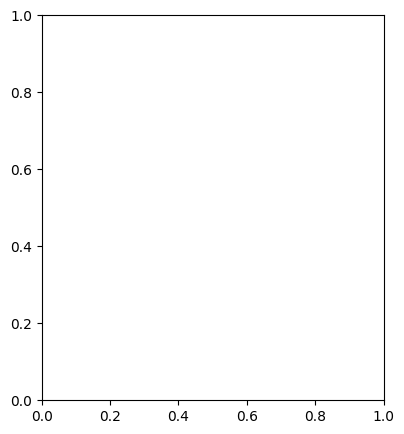

In [141]:
from PIL import Image
from datetime import datetime
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, deprocess_image,preprocess_image
import torch
from torch import nn
from torchvision import models, transforms

__classes = ["defect", "normal"]
def get_device_use():
    if torch.cuda.is_available():
        return torch.device('cuda')
    elif torch.backends.mps.is_available():
        return torch.device('mps')
    else:
        return torch.device('cpu')
device = get_device_use()

sdd_model = to_device(ResNet(3, 2), device)
sdd_model.load_state_dict(torch.load('./resnet9_sdd.pth'))
sdd_model.eval()

def inference(image_path:pathlib.Path) -> str:
    start_time = datetime.now()
    try:
        # image preprocessing (changable mean, std responding to dataset)
        _transformer = transform.Compose([transform.ToTensor(), transform.Normalize(mean=[0.2908, 0.2908, 0.2908], std=[0.9568, 0.9568, 0.9568])])
        _image = Image.open(image_path)
        _image = _transformer(_image).unsqueeze(0)
        
        with torch.no_grad():
            result = sdd_model(_image.cuda())
            _, preds  = torch.max(result, dim=1) # pick highest class label
            end_time = datetime.now()
            print(f"Elapsed Time : {end_time - start_time}")
            return __classes[preds[0].item()]
    except Exception as e:
        print(f"{e}")

# just inference    
inference("./test_normal.png")

class Flatten(nn.Module):
    """One layer module that flattens its input."""
    def __init__(self):
        super(Flatten, self).__init__()
    def forward(self, x):
        return x.view(x.size(0), -1)

def GradCAM(img, c, features_fn, classifier_fn):
    feats = features_fn(img.cuda())
    _, N, H, W = feats.size()
    out = classifier_fn(feats)
    c_score = out[0, c]
    grads = torch.autograd.grad(c_score, feats)
    w = grads[0][0].mean(-1).mean(-1)
    sal = torch.matmul(w, feats.view(N, H*W))
    sal = sal.view(H, W).cpu().detach().numpy()
    sal = np.maximum(sal, 0)
    return sal

read_tensor = transforms.Compose([
    lambda x: Image.open(x),
    lambda x: x.convert('RGB'),
    transforms.ToTensor(),
    transform.Normalize(mean=[0.2908, 0.2908, 0.2908], std=[0.9568, 0.9568, 0.9568]),
    lambda x: torch.unsqueeze(x, 0)
])

img_path = './test_defect.png'
img_tensor = read_tensor(img_path)
pp, cc = torch.topk(nn.Softmax(dim=1)(sdd_model(img_tensor.cuda())), 2)

features_fn = nn.Sequential(*list(sdd_model.children())[:-2])
print(features_fn)
classifier_fn = nn.Sequential(*(list(sdd_model.children())[-2:-1] + [Flatten()] + list(sdd_model.children())[-1:]))
print(classifier_fn)

plt.figure(figsize=(15, 5))
for i, (p, c) in enumerate(zip(pp[0], cc[0])):
    plt.subplot(1, 3, i+1)
    sal = GradCAM(img_tensor, int(c), features_fn, classifier_fn)
    img = Image.open(img_path)
    sal = Image.fromarray(sal)
    sal = sal.resize(img.size, resample=Image.LINEAR)

    #plt.title('{}: {:.1f}%'.format(get_class_name(c), 100*float(p)))
    #plt.axis('off')
    plt.imshow(img)
    plt.imshow(np.array(sal), alpha=0.5, cmap='jet')
plt.show()
    


In [130]:
from torch.autograd import GradCAM

ImportError: cannot import name 'GradCAM' from 'torch.autograd' (c:\Users\elecu\dev\flame-autonomous\venv\lib\site-packages\torch\autograd\__init__.py)

torch.Size([3, 400, 640])
<class 'torch.Tensor'>
Label: defect , Predicted: defect


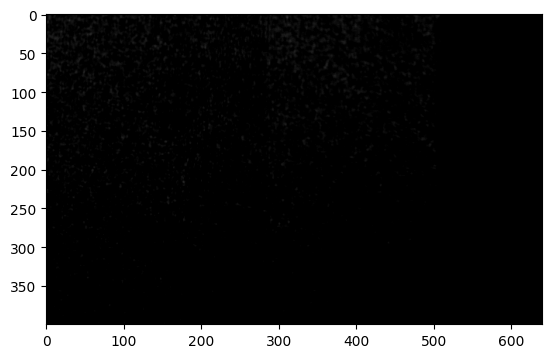

In [119]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    model.eval()
    with torch.no_grad():
        yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_dataset.classes[preds[0].item()]

img, label = test_dataset[99]
print(img.shape)
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print(type(img))
print('Label:', train_dataset.classes[label], ', Predicted:', predict_image(img, sdd_model))

# applied Grad-CAM
# from pytorch_grad_cam import GradCAM
# from pytorch_grad_cam.utils.image import show_cam_on_image, deprocess_image,preprocess_image
# from PIL import Image

# data = torchvision.io.read_image("./test.png")
# print("input tensor", type(data))

# test_image = Image.fromarray(img) 
# input_tensor = preprocess_image(test_image, mean=[0.2908, 0.2908, 0.2908], std=[0.9568, 0.9568, 0.9568])
# targets = [test_image]
# target_layers = [sdd_model.res2]
    
# with GradCAM(model=model, target_layers=target_layers) as cam:
#     grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
#     cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
# cam = np.uint8(255*grayscale_cams[0, :])
# cam = cv2.merge([cam, cam, cam])
# images = np.hstack((np.uint8(255*img), cam , cam_image))
# Image.fromarray(images)

In [75]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50
from torchvision import transforms
from PIL import Image

model = resnet50(pretrained=True)
target_layers = [model.layer4[-1]]
img, label = test_dataset[299]
data = torchvision.io.read_image("./test.png")
print(type(data))
img = Image.open("./test.png")
convert_tensor = transforms.ToTensor()
input_tesnsor = convert_tensor(img)
#input_tensor = img # Create an input tensor image for your model..
# Note: input_tensor can be a batch tensor with several images!

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers)

# You can also use it within a with statement, to make sure it is freed,
# In case you need to re-create it inside an outer loop:
# with GradCAM(model=model, target_layers=target_layers) as cam:
#   ...

# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category
# will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.

targets = [ClassifierOutputTarget(281)]

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

# You can also get the model outputs without having to re-inference
model_outputs = cam.outputs

c:\Users\elecu\dev\flame-autonomous\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\elecu\dev\flame-autonomous\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<class 'torch.Tensor'>


ValueError: expected 4D input (got 3D input)

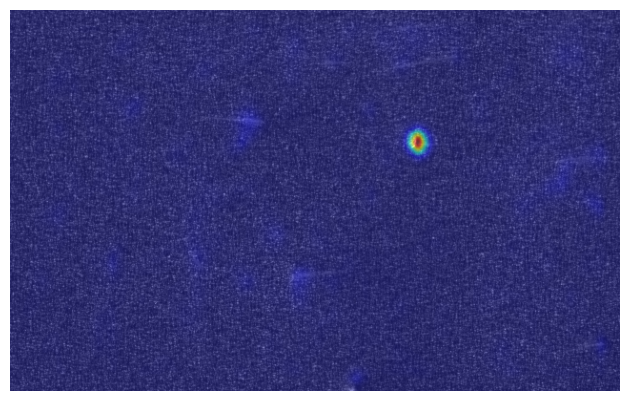

In [164]:
# Define your model
from torchvision.models import resnet18
model = resnet18(pretrained=True).eval()

# Set your CAM extractor
from torchcam.methods import SmoothGradCAMpp
cam_extractor = SmoothGradCAMpp(model)

from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchvision.models import resnet18
from torchcam.methods import SmoothGradCAMpp

#model = resnet18(pretrained=True).eval()

model = to_device(ResNet(3, 2), device)
model.load_state_dict(torch.load('./resnet9_sdd.pth'))
model.eval()

img = read_image("./test_defect3.png")

read_tensor = transforms.Compose([
    lambda x: Image.open(x),
    lambda x: x.convert('RGB'),
    transforms.ToTensor(),
    transform.Normalize(mean=[0.2908, 0.2908, 0.2908], std=[0.9568, 0.9568, 0.9568]),
    lambda x: torch.unsqueeze(x, 0)
])

img_path = './test_defect3.png'
input_tensor = read_tensor(img_path).cuda()

#_transformer = transform.Compose([transform.ToTensor(), transform.Normalize(mean=[0.2908, 0.2908, 0.2908], std=[0.9568, 0.9568, 0.9568])])
#_image = Image.open(img)
#input_tensor = _transformer(img).unsqueeze(0)

# Get your input

# Preprocess it for your chosen model
#input_tensor = normalize(resize(img, (400, 640)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

with SmoothGradCAMpp(model) as cam_extractor:
  # Preprocess your data and feed it to the model
  out = model(input_tensor)
  # Retrieve the CAM by passing the class index and the model output
  activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)
  
import matplotlib.pyplot as plt
from torchcam.utils import overlay_mask

# Resize the CAM and overlay it
result = overlay_mask(to_pil_image(img), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.5)
# Display it
plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.show()